In [1]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\111897


In [129]:
import pyodbc
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [130]:
cnxn = pyodbc.connect(driver='{SQL Server}', server='10.11.48.12', database='FZSRD_BD',               
               trusted_connection='yes')

#sql = 'SELECT top 10 * FROM v_customer_數位帳戶客戶'
sql = "SELECT top 2000 case when 性別='男' then 1 else 0 end as sex_male,性別 as sex, opening_date,age,JOB_TITLE_1,職業 as job,left(教育程度,1) as edu_i ,教育程度 as edu ,台外幣總存款餘額 as deposit_amt,當月AP總計 as ap_month,房貸開戶月 Mortgage_date,年齡 FROM v_customer_數位帳戶客戶"

data=pd.read_sql(sql, cnxn)

print(data.columns)

cnxn.close()

Index(['sex_male', 'sex', 'opening_date', 'age', 'JOB_TITLE_1', 'job', 'edu_i',
       'edu', 'deposit_amt', 'ap_month', 'Mortgage_date', '年齡'],
      dtype='object')


In [131]:
data.shape

(2000, 12)

In [132]:
print(data.describe())

          sex_male          age   deposit_amt      ap_month           年齡
count  2000.000000  2000.000000  2.000000e+03   2000.000000  2000.000000
mean      0.469500    36.413000  5.071375e+05    -89.591905    36.413000
std       0.499194     8.770798  3.869565e+05    994.015400     8.770798
min       0.000000    21.000000  0.000000e+00  -6577.390000    21.000000
25%       0.000000    30.000000  3.307850e+05   -252.012500    30.000000
50%       0.000000    35.000000  4.512165e+05   -216.560000    35.000000
75%       1.000000    41.000000  5.347661e+05   -127.412500    41.000000
max       1.000000    78.000000  8.211412e+06  22519.116000    78.000000


In [64]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex_male       1000 non-null   int64  
 1   sex            1000 non-null   object 
 2   opening_date   1000 non-null   object 
 3   age            1000 non-null   int64  
 4   JOB_TITLE_1    1000 non-null   object 
 5   job            1000 non-null   object 
 6   edu_i          1000 non-null   object 
 7   edu            1000 non-null   object 
 8   deposit_amt    1000 non-null   float64
 9   ap_month       1000 non-null   float64
 10  Mortgage_date  1000 non-null   object 
 11  年齡             1000 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 93.9+ KB


### exclude outlier

In [65]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(Q1["age"])
print(Q3["age"])
print(IQR["age"])
IQR

30.0
41.0
11.0


sex_male            1.000
age                11.000
deposit_amt    190487.500
ap_month          121.815
年齡                 11.000
dtype: float64

In [66]:
data = data[(data["ap_month"]>=Q1["ap_month"]-IQR["ap_month"]*1.5) & (data["ap_month"]<=Q3["ap_month"]+IQR["ap_month"]*1.5)]

In [67]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex_male       788 non-null    int64  
 1   sex            788 non-null    object 
 2   opening_date   788 non-null    object 
 3   age            788 non-null    int64  
 4   JOB_TITLE_1    788 non-null    object 
 5   job            788 non-null    object 
 6   edu_i          788 non-null    object 
 7   edu            788 non-null    object 
 8   deposit_amt    788 non-null    float64
 9   ap_month       788 non-null    float64
 10  Mortgage_date  788 non-null    object 
 11  年齡             788 non-null    int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 80.0+ KB


In [68]:
data["age"] = data["age"].astype(int)
data["ap_month"] = data["ap_month"].astype(int)
#data["房貸開戶月"] = data["房貸開戶月"].astype(str)
data["Mortgage_date"] = data["Mortgage_date"].astype('category')


In [69]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   sex_male       788 non-null    int64   
 1   sex            788 non-null    object  
 2   opening_date   788 non-null    object  
 3   age            788 non-null    int32   
 4   JOB_TITLE_1    788 non-null    object  
 5   job            788 non-null    object  
 6   edu_i          788 non-null    object  
 7   edu            788 non-null    object  
 8   deposit_amt    788 non-null    float64 
 9   ap_month       788 non-null    int32   
 10  Mortgage_date  788 non-null    category
 11  年齡             788 non-null    int64   
dtypes: category(1), float64(1), int32(2), int64(2), object(6)
memory usage: 68.6+ KB


In [70]:
data.dtypes

sex_male            int64
sex                object
opening_date       object
age                 int32
JOB_TITLE_1        object
job                object
edu_i              object
edu                object
deposit_amt       float64
ap_month            int32
Mortgage_date    category
年齡                  int64
dtype: object

In [71]:
data.head(10)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29
2,1,男,20200416,37,7,12軍警機構,4,4大學,453581.0,-6,Non_非房貸戶,37
3,1,男,20200106,40,7,32電子業,5,5碩士,447472.0,-18,Non_非房貸戶,40
4,0,女,20200414,29,5,01金融業,4,4大學,400970.0,-205,Non_非房貸戶,29
6,0,女,20200211,57,8,07製造業,4,4大學,337061.0,47,Non_非房貸戶,57
7,1,男,20200416,25,11,20住宿及餐飲業,4,4大學,380447.0,-196,Non_非房貸戶,25
8,1,男,20190624,41,5,33大眾傳播,5,5碩士,240140.0,-198,Non_非房貸戶,41
9,1,男,20200222,44,1,27無業,5,5碩士,453107.0,-241,Non_非房貸戶,44
10,0,女,20200508,36,3,21運輸或倉儲及通訊業,4,4大學,501140.0,-261,Non_非房貸戶,36


In [72]:
data_dummy = pd.get_dummies(data, columns=['sex','edu'])
data_dummy.head(10)

,sex_male,opening_date,age,JOB_TITLE_1,job,edu_i,deposit_amt,ap_month,Mortgage_date,年齡,sex_女,sex_男,edu_1國中,edu_2高中,edu_3專科,edu_4大學,edu_5碩士,edu_6博士以上,edu_7其他
0,0,20200309,35,4,36醫療保健,4,380523.0,-205,Non_非房貸戶,35,1,0,0,0,0,1,0,0,0
1,1,20200526,29,5,01金融業,5,500000.0,-237,Non_非房貸戶,29,0,1,0,0,0,0,1,0,0
2,1,20200416,37,7,12軍警機構,4,453581.0,-6,Non_非房貸戶,37,0,1,0,0,0,1,0,0,0
3,1,20200106,40,7,32電子業,5,447472.0,-18,Non_非房貸戶,40,0,1,0,0,0,0,1,0,0
4,0,20200414,29,5,01金融業,4,400970.0,-205,Non_非房貸戶,29,1,0,0,0,0,1,0,0,0
6,0,20200211,57,8,07製造業,4,337061.0,47,Non_非房貸戶,57,1,0,0,0,0,1,0,0,0
7,1,20200416,25,11,20住宿及餐飲業,4,380447.0,-196,Non_非房貸戶,25,0,1,0,0,0,1,0,0,0
8,1,20190624,41,5,33大眾傳播,5,240140.0,-198,Non_非房貸戶,41,0,1,0,0,0,0,1,0,0
9,1,20200222,44,1,27無業,5,453107.0,-241,Non_非房貸戶,44,0,1,0,0,0,0,1,0,0
10,0,20200508,36,3,21運輸或倉儲及通訊業,4,501140.0,-261,Non_非房貸戶,36,1,0,0,0,0,1,0,0,0


### 變數次數分佈

Text(0.5, 1, 'count of edu')

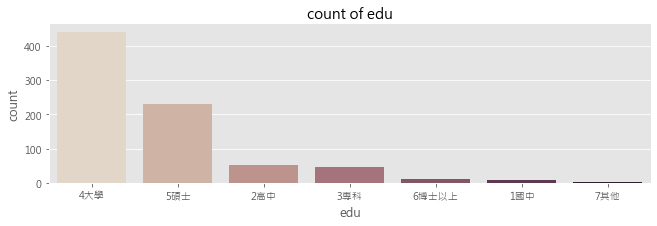

In [73]:
import pandas as pd
import seaborn as sns #Visualization
from matplotlib import pyplot as plt


sns.catplot(x="edu", kind="count", data=data, color='r', palette="ch:.25",height=3, aspect=3)
plt.title('count of edu')


#data['job'].value_counts().head(30).plot(kind='barh', figsize=(6,15))
#plt.title('count of job')

#plt.show()

Text(0.5, 1.0, 'Distribution of deposit_amt')

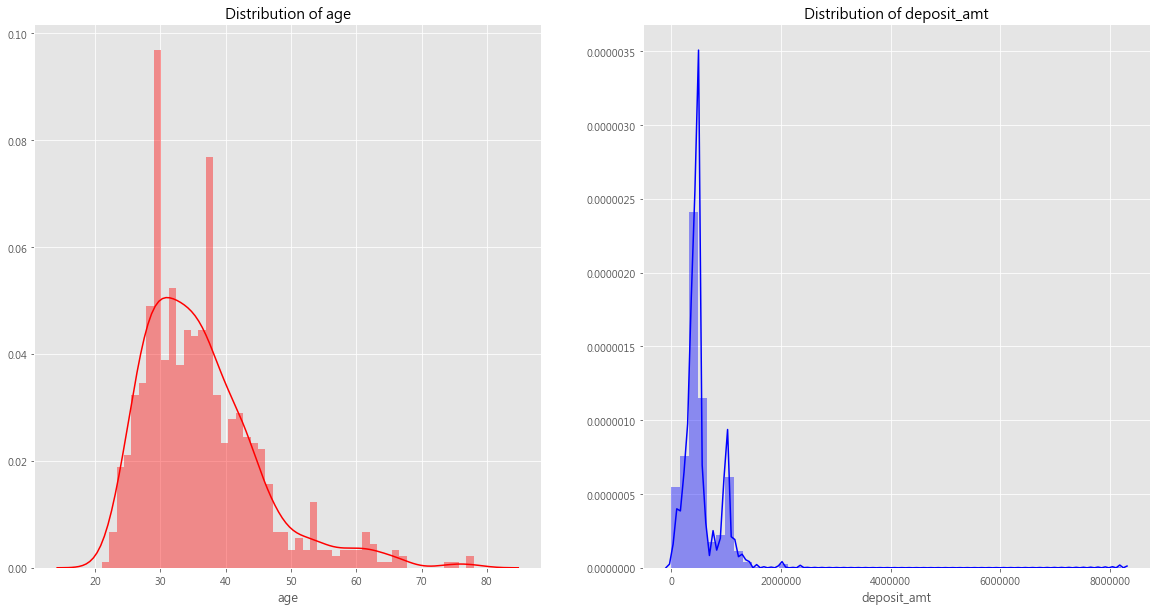

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

f= plt.figure(figsize=(20,10))

ax=f.add_subplot(121)
sns.distplot(data['age'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of age')

ax=f.add_subplot(122)
sns.distplot(data['deposit_amt'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of deposit_amt')



Text(0.5, 1.0, 'Distribution of ap_month')

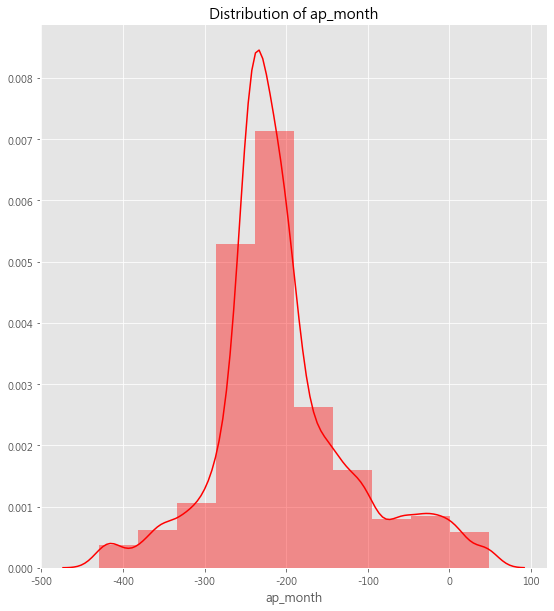

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

f= plt.figure(figsize=(20,10))


ax=f.add_subplot(121)
sns.distplot(data['ap_month'],bins=10,color='r',ax=ax)
ax.set_title('Distribution of ap_month')



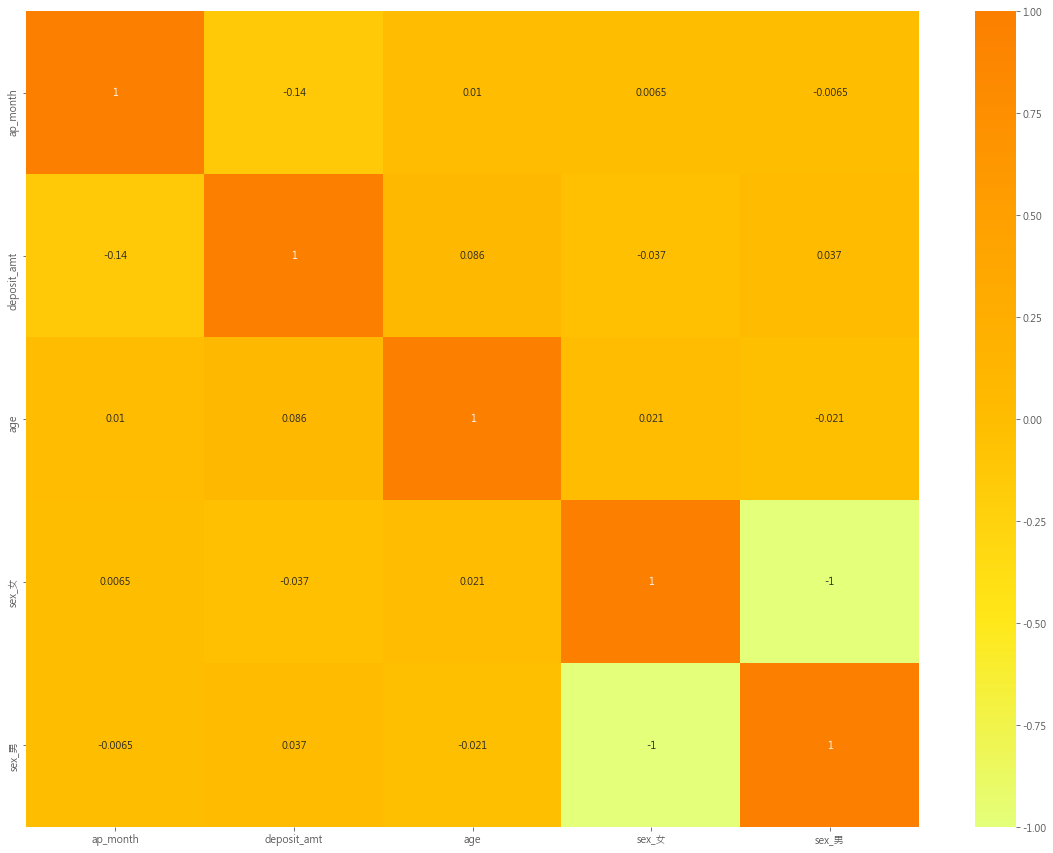

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

# correlation plot
#corr = data_dummy.corr()
corr = data_dummy[['ap_month','deposit_amt','age','sex_女','sex_男']].corr()

plt.subplots(figsize=(20,15))
#sns.set(font_scale=1.4)

sns.heatmap(corr, cmap = 'Wistia', annot= True)

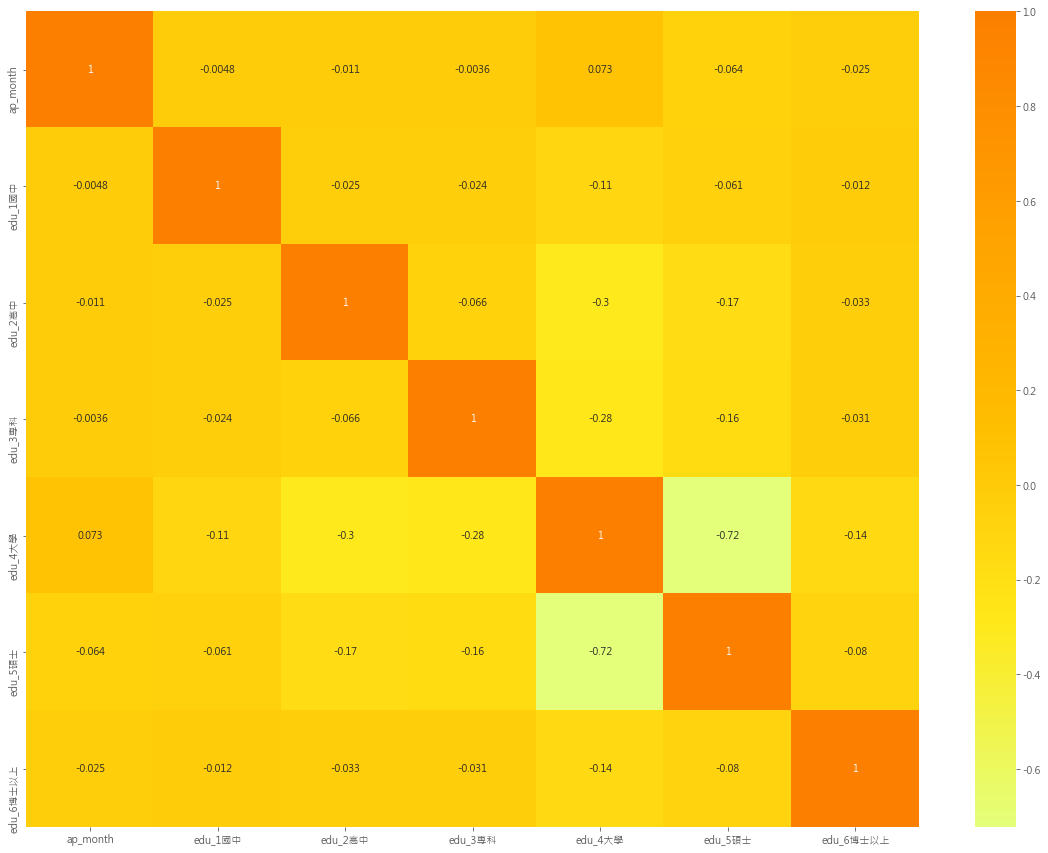

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

corr = data_dummy[['ap_month','edu_1國中','edu_2高中','edu_3專科','edu_4大學','edu_5碩士','edu_6博士以上']].corr()

plt.subplots(figsize=(20,15))

sns.heatmap(corr, cmap = 'Wistia', annot= True);



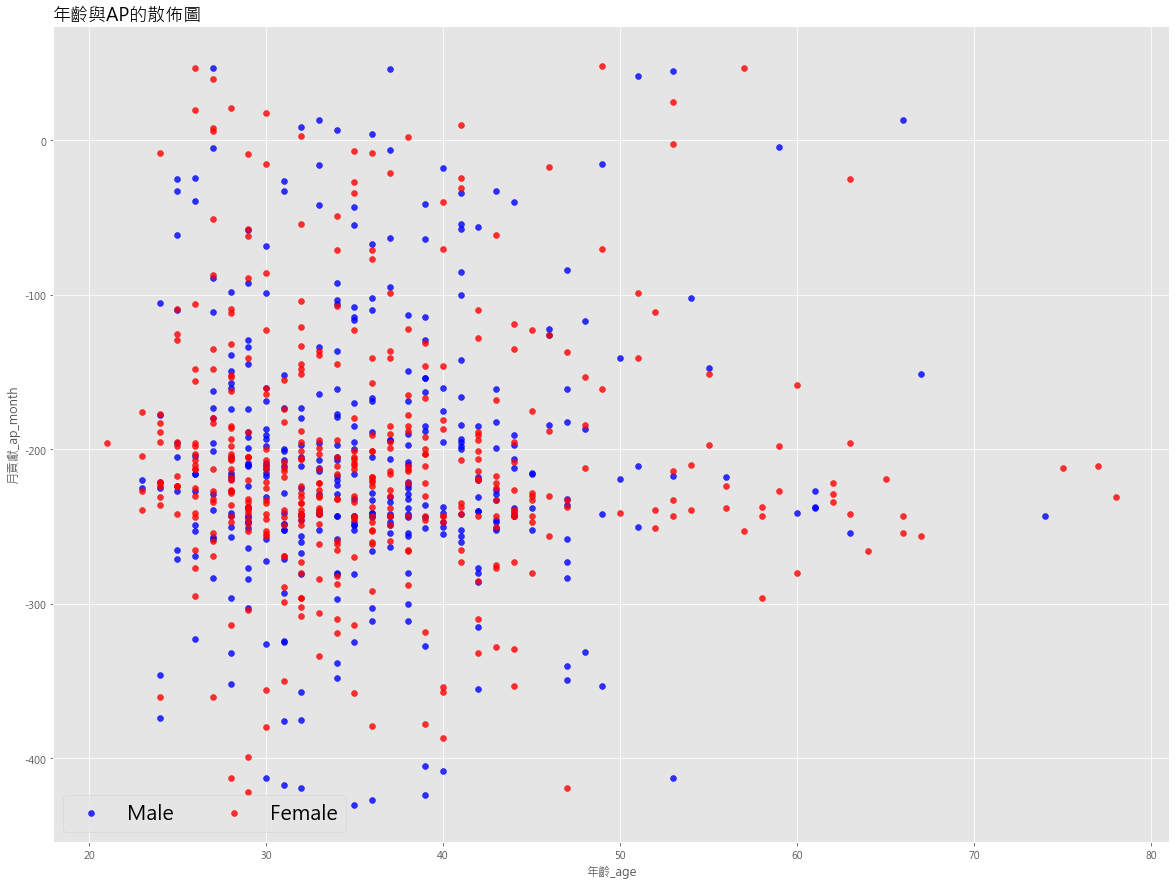

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

plt.rcParams.update(
    {'font.sans-serif': 'Microsoft JhengHei', 'axes.unicode_minus': False})
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 15))

#labels = np.random.choice(['a', 'b', 'c'], num)

scatter_male = plt.scatter(x=data[data['sex']=="男"]['age'],y=data[data['sex']=="男"]['ap_month'],color='blue', alpha=0.8)
scatter_female = plt.scatter(x=data[data['sex']=="女"]['age'],y=data[data['sex']=="女"]['ap_month'],color='red', alpha=0.8)
#plt.scatter(x=data[data['sex']=="男"]['age'],y=data[data['sex']=="男"]['ap_month'],='blue')



plt.title('年齡與AP的散佈圖', fontsize=18, loc='left', color='black')
plt.xlabel('年齡_age')
plt.ylabel('月貢獻_ap_month')

plt.legend((scatter_male, scatter_female),
           ('Male', 'Female'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=20)

plt.show()

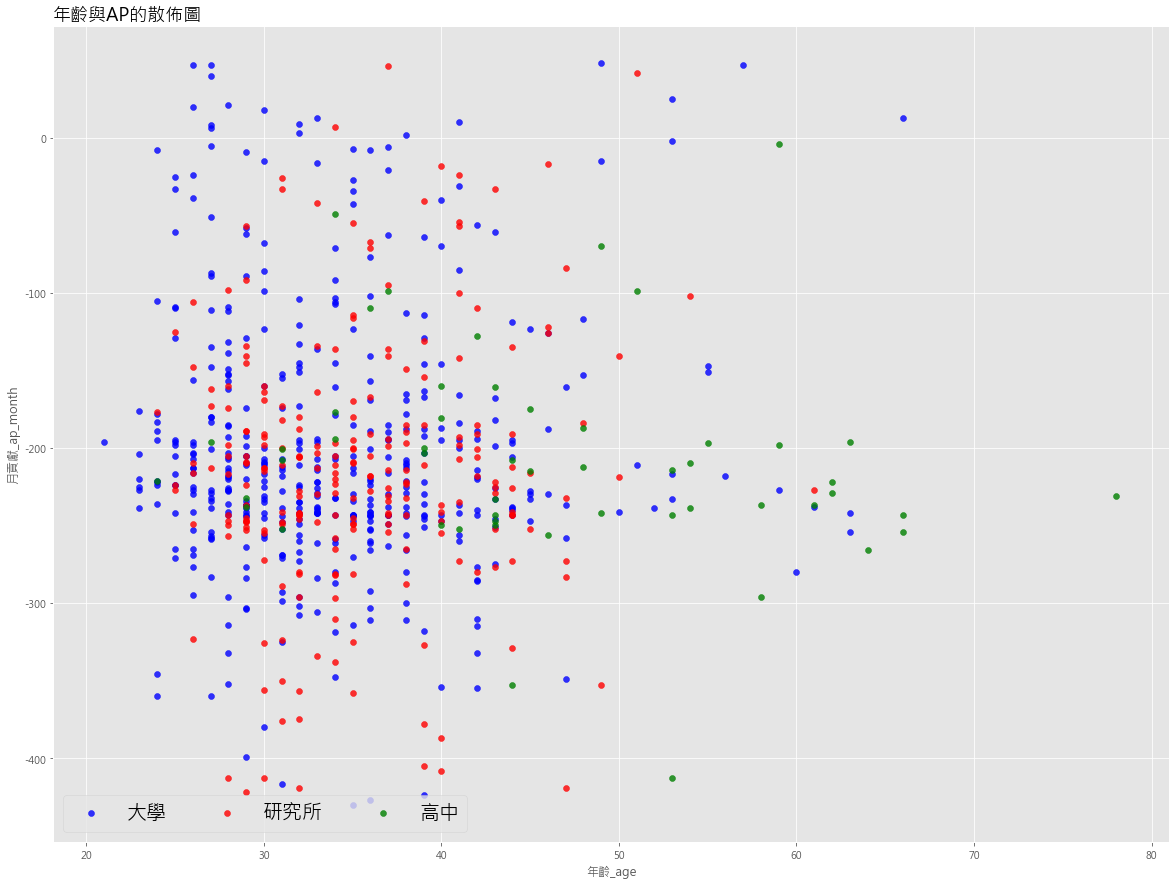

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

plt.rcParams.update(
    {'font.sans-serif': 'Microsoft JhengHei', 'axes.unicode_minus': False})
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 15))

#labels = np.random.choice(['a', 'b', 'c'], num)

scatter_Bachelor = plt.scatter(x=data[data['edu']=="4大學"]['age'],y=data[data['edu']=="4大學"]['ap_month'],color='blue', alpha=0.8)
scatter_Master = plt.scatter(x=data[data['edu']=="5碩士"]['age'],y=data[data['edu']=="5碩士"]['ap_month'],color='red', alpha=0.8)
scatter_Highschool = plt.scatter(x=data[data['edu']=="2高中"]['age'],y=data[data['edu']=="2高中"]['ap_month'],color='green', alpha=0.8)

plt.legend((scatter_Bachelor, scatter_Master,scatter_Highschool),
           ('大學', '研究所', '高中'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=20)


#plt.scatter(x=data['age'],y=data['ap_month'])
#plt.scatter(data['age'],data['ap_month'])
plt.title('年齡與AP的散佈圖', fontsize=18, loc='left', color='black')
plt.xlabel('年齡_age')
plt.ylabel('月貢獻_ap_month')
plt.show()

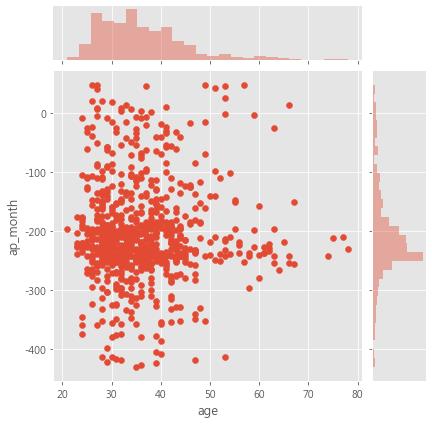

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

sns.jointplot(x='age',y ='ap_month', data = data)

In [81]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
reg = linear_model.LinearRegression()

In [82]:
data.head(2)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29


In [86]:
data_dummy.head(2)

,sex_male,opening_date,age,JOB_TITLE_1,job,edu_i,deposit_amt,ap_month,Mortgage_date,年齡,sex_女,sex_男,edu_1國中,edu_2高中,edu_3專科,edu_4大學,edu_5碩士,edu_6博士以上,edu_7其他
0,0,20200309,35,4,36醫療保健,4,380523.0,-205,Non_非房貸戶,35,1,0,0,0,0,1,0,0,0
1,1,20200526,29,5,01金融業,5,500000.0,-237,Non_非房貸戶,29,0,1,0,0,0,0,1,0,0


### 簡單廻歸

In [88]:
len(data['age'])
#x = np.array(data.iloc[:,-1])
x = np.array(data_dummy.iloc[:,2])#age
#y = np.array(data.iloc[:,-3])
y = np.array(data_dummy.iloc[:,7])#ap

x = x.reshape(-1,1)

#plt.scatter(x=x,y=y,color='blue', alpha=0.8)
#plt.show()

#print(x)
#print(y)
reg.fit(x,y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
reg.coef_

array([0.09624514])

In [90]:
data.head(10)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29
2,1,男,20200416,37,7,12軍警機構,4,4大學,453581.0,-6,Non_非房貸戶,37
3,1,男,20200106,40,7,32電子業,5,5碩士,447472.0,-18,Non_非房貸戶,40
4,0,女,20200414,29,5,01金融業,4,4大學,400970.0,-205,Non_非房貸戶,29
6,0,女,20200211,57,8,07製造業,4,4大學,337061.0,47,Non_非房貸戶,57
7,1,男,20200416,25,11,20住宿及餐飲業,4,4大學,380447.0,-196,Non_非房貸戶,25
8,1,男,20190624,41,5,33大眾傳播,5,5碩士,240140.0,-198,Non_非房貸戶,41
9,1,男,20200222,44,1,27無業,5,5碩士,453107.0,-241,Non_非房貸戶,44
10,0,女,20200508,36,3,21運輸或倉儲及通訊業,4,4大學,501140.0,-261,Non_非房貸戶,36


In [91]:
reg.predict(x)
data['ap_month_pre'] = reg.predict(x)

In [92]:
data.head(10)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡,ap_month_pre
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35,-205.019436
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29,-205.596907
2,1,男,20200416,37,7,12軍警機構,4,4大學,453581.0,-6,Non_非房貸戶,37,-204.826946
3,1,男,20200106,40,7,32電子業,5,5碩士,447472.0,-18,Non_非房貸戶,40,-204.538210
4,0,女,20200414,29,5,01金融業,4,4大學,400970.0,-205,Non_非房貸戶,29,-205.596907
6,0,女,20200211,57,8,07製造業,4,4大學,337061.0,47,Non_非房貸戶,57,-202.902043
7,1,男,20200416,25,11,20住宿及餐飲業,4,4大學,380447.0,-196,Non_非房貸戶,25,-205.981887
8,1,男,20190624,41,5,33大眾傳播,5,5碩士,240140.0,-198,Non_非房貸戶,41,-204.441965
9,1,男,20200222,44,1,27無業,5,5碩士,453107.0,-241,Non_非房貸戶,44,-204.153230
10,0,女,20200508,36,3,21運輸或倉儲及通訊業,4,4大學,501140.0,-261,Non_非房貸戶,36,-204.923191


In [93]:
a = reg.intercept_
print("intercept: {0}".format(a))

a = reg.coef_
print("coef: {0}".format(a))


intercept: -208.38801562641234
coef: [0.09624514]


### R-square

In [94]:
from sklearn.metrics import r2_score

y_true = data['ap_month']
y_pred = data['ap_month_pre']
r2_score(y_true, y_pred)

0.00010605564518140209

###  複廻歸-(2個x變數)

In [97]:
#x = np.array(data.iloc[:,-1])
#x = np.array(data_dummy.iloc[:,[1,4]])#age & deposit_amt
x = data_dummy[["age","deposit_amt"]]#age & deposit_amt
#y = np.array(data.iloc[:,-3])
#y = np.array(data_dummy.iloc[:,5])#ap
y = data_dummy[["ap_month"]]#ap


#x = x.reshape(-1,1)

print("x {0}".format(x))
print("y {0}".format(y))

#print("x_1 {0}".format(data_dummy.iloc[:,[1]].head(3)))
#print("x_4 {0}".format(data_dummy.iloc[:,[4]].head(3)))
#print("y_1 {0}".format(data_dummy.iloc[:,[5]].head(3)))


reg.fit(x,y)

x      age  deposit_amt
0     35     380523.0
1     29     500000.0
2     37     453581.0
3     40     447472.0
4     29     400970.0
..   ...          ...
995   39     481767.0
996   31     437449.0
997   34     151690.0
998   34     534337.0
999   39     496088.0

[788 rows x 2 columns]
y      ap_month
0        -205
1        -237
2          -6
3         -18
4        -205
..        ...
995      -185
996      -289
997      -136
998      -205
999      -327

[788 rows x 1 columns]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
reg.coef_

array([[ 2.08931433e-01, -2.84045360e-05]])

In [99]:
x.columns

Index(['age', 'deposit_amt'], dtype='object')

In [100]:
from sklearn.metrics import r2_score

y_true = data['ap_month']
y_pred = data['ap_month_pre']
r2_score(y_true, y_pred)

0.00010605564518140209

In [101]:
data_dummy.head(5)

,sex_male,opening_date,age,JOB_TITLE_1,job,edu_i,deposit_amt,ap_month,Mortgage_date,年齡,sex_女,sex_男,edu_1國中,edu_2高中,edu_3專科,edu_4大學,edu_5碩士,edu_6博士以上,edu_7其他
0,0,20200309,35,4,36醫療保健,4,380523.0,-205,Non_非房貸戶,35,1,0,0,0,0,1,0,0,0
1,1,20200526,29,5,01金融業,5,500000.0,-237,Non_非房貸戶,29,0,1,0,0,0,0,1,0,0
2,1,20200416,37,7,12軍警機構,4,453581.0,-6,Non_非房貸戶,37,0,1,0,0,0,1,0,0,0
3,1,20200106,40,7,32電子業,5,447472.0,-18,Non_非房貸戶,40,0,1,0,0,0,0,1,0,0
4,0,20200414,29,5,01金融業,4,400970.0,-205,Non_非房貸戶,29,1,0,0,0,0,1,0,0,0


###  複廻歸-(n個x變數)

In [115]:
#x = np.array(data.iloc[:,-1])
#x = np.array(data_dummy.iloc[:,[1,4,8,9,10,11,12,13,14,15,16]])#age & deposit_amt
#x = data_dummy[["age","deposit_amt","sex_女","sex_男","edu_1國中","edu_2高中","edu_3專科","edu_4大學","edu_5碩士","edu_6博士以上","edu_7其他"]]#age & deposit_amt
x = data_dummy[["age","deposit_amt","sex_male","edu_i"]]#age & deposit_amt

#y = np.array(data.iloc[:,-3])
#y = np.array(data_dummy.iloc[:,5])#ap
y = data_dummy[["ap_month"]]#ap

#x = x.reshape(-1,1)

print("x {0}".format(x))
print("y {0}".format(y))

#print("x_1 {0}".format(data_dummy.iloc[:,[1]].head(3)))
#print("x_4 {0}".format(data_dummy.iloc[:,[4]].head(3)))
#print("x_8 {0}".format(data_dummy.iloc[:,[8]].head(3)))
#print("x_9 {0}".format(data_dummy.iloc[:,[9]].head(3)))
#print("x_10 {0}".format(data_dummy.iloc[:,[10]].head(3)))
#print("x_16 {0}".format(data_dummy.iloc[:,[16]].head(3)))
#print("y_1 {0}".format(data_dummy.iloc[:,[5]].head(3)))


reg.fit(x,y)

x      age  deposit_amt  sex_male edu_i
0     35     380523.0         0     4
1     29     500000.0         1     5
2     37     453581.0         1     4
3     40     447472.0         1     5
4     29     400970.0         0     4
..   ...          ...       ...   ...
995   39     481767.0         1     5
996   31     437449.0         0     5
997   34     151690.0         1     5
998   34     534337.0         0     5
999   39     496088.0         1     5

[788 rows x 4 columns]
y      ap_month
0        -205
1        -237
2          -6
3         -18
4        -205
..        ...
995      -185
996      -289
997      -136
998      -205
999      -327

[788 rows x 1 columns]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
a = reg.intercept_
print("intercept: {0}".format(a))
      
a = reg.coef_
print("coef: {0}".format(a))    

a = x.columns
print("x_columns: {0}".format(a))    

intercept: [-184.09126656]
coef: [[ 1.30433603e-01 -2.82410993e-05  6.27862710e-01 -2.71372171e+00]]
x_columns: Index(['age', 'deposit_amt', 'sex_male', 'edu_i'], dtype='object')


In [110]:
a = reg.intercept_
print("intercept: {0}".format(a))



#pd.DataFrame(reg.coef_ , x.columns, columns=['Coeffecient'])
pd.DataFrame([ 1.30433603e-01, -2.82410993e-05,  6.27862710e-01, -2.71372171e+00] , x.columns, columns=['Coeffecient'])

intercept: [-184.09126656]


,Coeffecient
age,0.130434
deposit_amt,-0.000028
sex_male,0.627863
edu_i,-2.713722


In [105]:
data.head(10)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡,ap_month_pre
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35,-205.019436
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29,-205.596907
2,1,男,20200416,37,7,12軍警機構,4,4大學,453581.0,-6,Non_非房貸戶,37,-204.826946
3,1,男,20200106,40,7,32電子業,5,5碩士,447472.0,-18,Non_非房貸戶,40,-204.538210
4,0,女,20200414,29,5,01金融業,4,4大學,400970.0,-205,Non_非房貸戶,29,-205.596907
6,0,女,20200211,57,8,07製造業,4,4大學,337061.0,47,Non_非房貸戶,57,-202.902043
7,1,男,20200416,25,11,20住宿及餐飲業,4,4大學,380447.0,-196,Non_非房貸戶,25,-205.981887
8,1,男,20190624,41,5,33大眾傳播,5,5碩士,240140.0,-198,Non_非房貸戶,41,-204.441965
9,1,男,20200222,44,1,27無業,5,5碩士,453107.0,-241,Non_非房貸戶,44,-204.153230
10,0,女,20200508,36,3,21運輸或倉儲及通訊業,4,4大學,501140.0,-261,Non_非房貸戶,36,-204.923191


In [106]:
reg.predict(x)

array([[-201.1273651 ],
       [-207.36998753],
       [-202.30187342],
       [-204.45176944],
       [-202.48741248],
       [-197.03041119],
       [-201.8016921 ],
       [-198.46605225],
       [-204.08917362],
       [-204.40328817],
       [-195.82831451],
       [-203.24902261],
       [-196.84196987],
       [-202.41200409],
       [-202.92724801],
       [-198.04162076],
       [-197.03535452],
       [-206.09771398],
       [-203.34073302],
       [-207.03614358],
       [-199.36647191],
       [-202.0401906 ],
       [-203.28827436],
       [-200.76851284],
       [-195.45402819],
       [-202.60318974],
       [-206.79114176],
       [-204.17858173],
       [-202.59874849],
       [-196.86243365],
       [-198.61743649],
       [-195.76641534],
       [-203.86162806],
       [-202.03642329],
       [-201.32255555],
       [-202.79029827],
       [-203.45062331],
       [-205.51800074],
       [-207.08724134],
       [-205.7568014 ],
       [-190.88688448],
       [-202.964

In [107]:
data['ap_month_pre'] = reg.predict(x)
data.head(10)

,sex_male,sex,opening_date,age,JOB_TITLE_1,job,edu_i,edu,deposit_amt,ap_month,Mortgage_date,年齡,ap_month_pre
0,0,女,20200309,35,4,36醫療保健,4,4大學,380523.0,-205,Non_非房貸戶,35,-201.127365
1,1,男,20200526,29,5,01金融業,5,5碩士,500000.0,-237,Non_非房貸戶,29,-207.369988
2,1,男,20200416,37,7,12軍警機構,4,4大學,453581.0,-6,Non_非房貸戶,37,-202.301873
3,1,男,20200106,40,7,32電子業,5,5碩士,447472.0,-18,Non_非房貸戶,40,-204.451769
4,0,女,20200414,29,5,01金融業,4,4大學,400970.0,-205,Non_非房貸戶,29,-202.487412
6,0,女,20200211,57,8,07製造業,4,4大學,337061.0,47,Non_非房貸戶,57,-197.030411
7,1,男,20200416,25,11,20住宿及餐飲業,4,4大學,380447.0,-196,Non_非房貸戶,25,-201.801692
8,1,男,20190624,41,5,33大眾傳播,5,5碩士,240140.0,-198,Non_非房貸戶,41,-198.466052
9,1,男,20200222,44,1,27無業,5,5碩士,453107.0,-241,Non_非房貸戶,44,-204.089174
10,0,女,20200508,36,3,21運輸或倉儲及通訊業,4,4大學,501140.0,-261,Non_非房貸戶,36,-204.403288


### R-square

In [108]:
from sklearn.metrics import r2_score

y_true = data['ap_month']
y_pred = data['ap_month_pre']
r2_score(y_true, y_pred)

0.02016635036705483

In [109]:
reg.score(x,y) #驗證模型正確性,不同模型有不同的驗證指標
                     #linearRegression預設使用決定係數(R2)當作指標,越接近1越好

0.02016635036705483

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex_male       2000 non-null   int64  
 1   sex            2000 non-null   object 
 2   opening_date   2000 non-null   object 
 3   age            2000 non-null   int64  
 4   JOB_TITLE_1    2000 non-null   object 
 5   job            2000 non-null   object 
 6   edu_i          2000 non-null   object 
 7   edu            2000 non-null   object 
 8   deposit_amt    2000 non-null   float64
 9   ap_month       2000 non-null   float64
 10  Mortgage_date  2000 non-null   object 
 11  年齡             2000 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 187.6+ KB


In [136]:
data["age"] = data["age"].astype(int)
data["deposit_amt"] = data["deposit_amt"].astype(int)
data["sex_male"] = data["sex_male"].astype(int)
data["edu_i"] = data["edu_i"].astype(int)
data["ap_month"] = data["ap_month"].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sex_male       2000 non-null   int32 
 1   sex            2000 non-null   object
 2   opening_date   2000 non-null   object
 3   age            2000 non-null   int32 
 4   JOB_TITLE_1    2000 non-null   object
 5   job            2000 non-null   object
 6   edu_i          2000 non-null   int32 
 7   edu            2000 non-null   object
 8   deposit_amt    2000 non-null   int32 
 9   ap_month       2000 non-null   int32 
 10  Mortgage_date  2000 non-null   object
 11  年齡             2000 non-null   int64 
dtypes: int32(5), int64(1), object(6)
memory usage: 148.6+ KB


### xgboost

In [137]:
from xgboost import XGBClassifier

x = data[["age","deposit_amt","sex_male","edu_i"]]#age & deposit_amt
y = data[["ap_month"]]#ap

xgbc = XGBClassifier()
xgbc.fit(x,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [139]:
xgbc.score(x,y)##????

0.872

In [141]:
from sklearn.model_selection import train_test_split

#wine_df = pd.read_csv('winequality-red.csv',sep=';')
ap_data = data.drop('ap_month',axis=1)
ap_data = ap_data[["age","deposit_amt","sex_male","edu_i",]]
ap_label = data["ap_month"]
train_ap_data, test_ap_data, train_ap_label, test_ap_label = train_test_split(ap_data, ap_label)

In [142]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(train_ap_data,train_ap_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
xgbc.score(train_ap_data,train_ap_label)

0.856

In [143]:
xgbc.score(test_ap_data,test_ap_label)

0.016

In [145]:
xgbc_v1 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=8,min_child_weight=1,
                        gamma=0.4,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',
                        nthread=4,scale_pos_weight=1,seed=27)
xgbc_v1.fit(x,y)
xgbc_v1.score(x,y)

[11:58:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.6445

### XGBClassifier 參數說明

##### 1、objective[默認reg:linear] 這個參數定義需要被最小化的損失函數。最常用的值有：binary:logistic 二分類的邏輯回歸，返回預測的概率(不是類別)。multi:softmax 使用softmax的多分類器，返回預測的類別(不是概率)。在這種情況下，你還需要多設一個參數：num_class(類別數目)。multi:softprob 和multi:softmax參數一樣，但是返回的是每個數據屬於各個類別的概率。

##### 其他參數說明
##### https://www.itread01.com/articles/1476146171.html
##### https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


##### https://blog.csdn.net/wf592523813/article/details/80111097

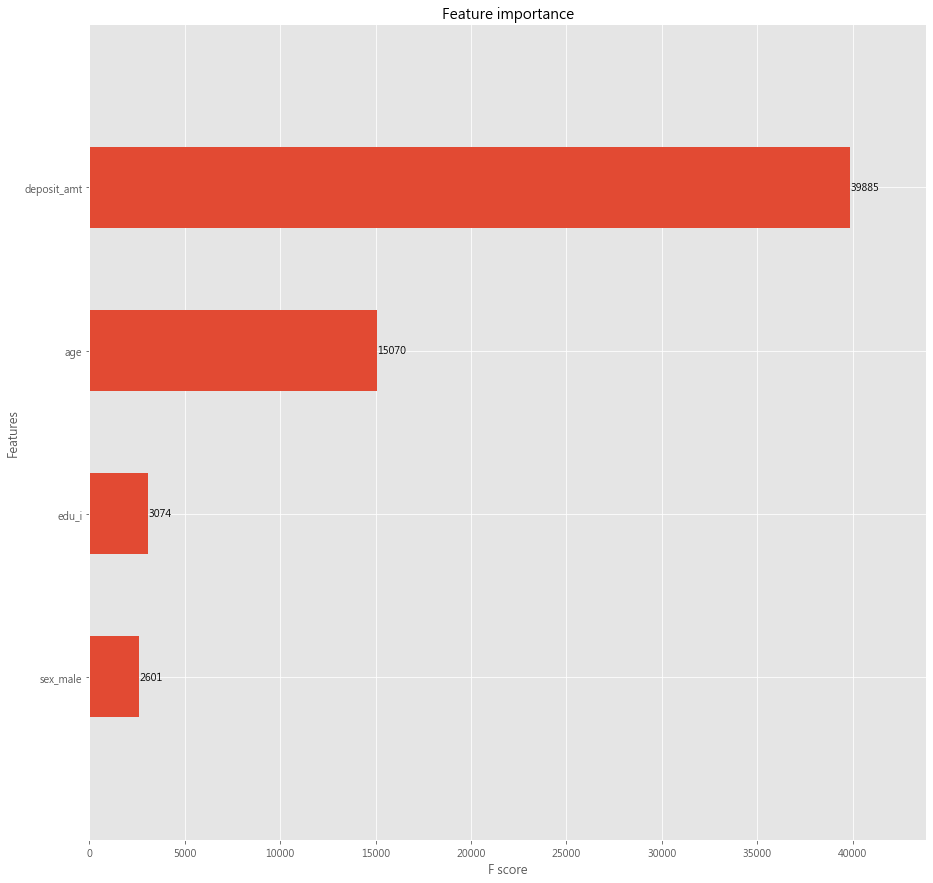

In [128]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgbc_v1,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()